In [1]:
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim  as optim
import time
import os
from torchvision.transforms.functional import to_pil_image
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1

In [4]:
transforms = transforms.Compose(
  [
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
      [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
    ),
  ]
)


In [5]:
dataset = datasets.MNIST(root="./Desktop", train=True, transform=transforms,
                       download=True)
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
data, img = iter(trainloader).next()
data.size()

torch.Size([64, 1, 28, 28])

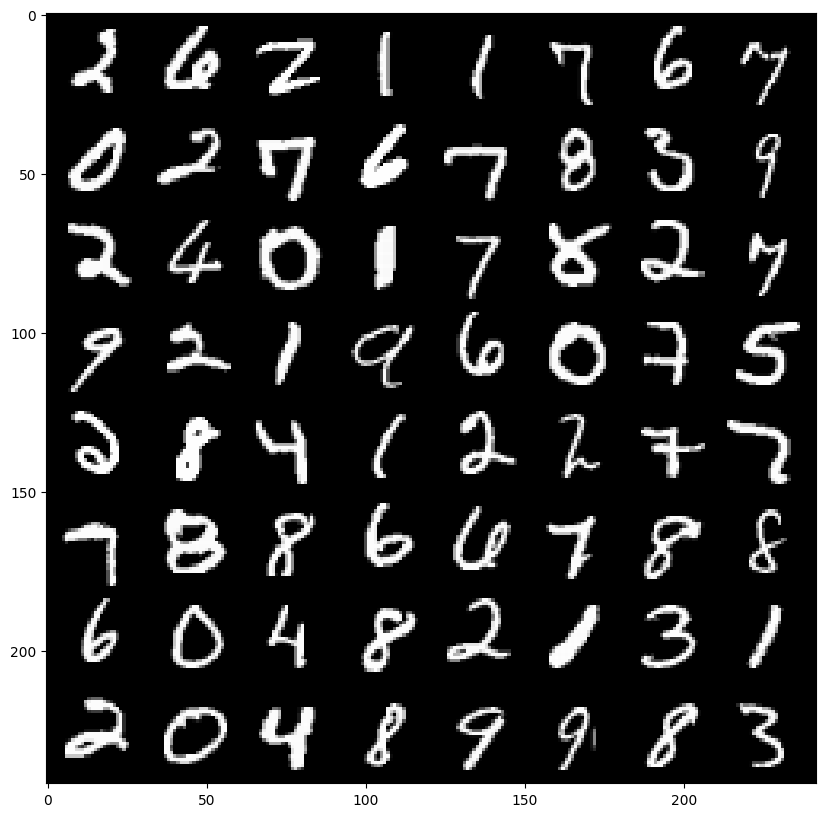

In [7]:
def img_show(img):
    plt.figure(figsize = (10, 10))
    plt.imshow(torchvision.utils.make_grid(img, normalize = True).permute(1,2,0)) # H, W, C로 변경
    plt.show()

for data, label in trainloader:
    img_show(data)
    break

In [8]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, num_classes, num_noises, input_size, features_gen):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.num_noises = num_noises
        self.input_size = input_size
        self.features_gen = features_gen 
        
        self.label_emb = nn.Embedding(num_embeddings=self.num_classes, 
                                      embedding_dim=self.num_classes)
        self.gen = nn.Sequential(
            nn.Linear(self.num_noises + self.num_classes, features_gen),
            nn.LeakyReLU(0.2),
            self._block(features_gen, features_gen * 2),
            self._block(features_gen * 2, features_gen * 4),
            self._block(features_gen * 4, features_gen * 8),
            nn.Linear(features_gen * 8, np.prod(self.input_size)),
            nn.Tanh()
        )
    
    def _block(self, input, output):
        return nn.Sequential(
            nn.Linear(input, output),
            nn.BatchNorm1d(output),  # 선형 레이어에는 BatchNorm1d를 사용합니다.
            nn.LeakyReLU(0.2),
        )  
    
    def forward(self, noise, labels):
        gan_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.gen(gan_input)
        x = x.view(x.size(0), *self.input_size)
        return x


In [9]:
check_x = torch.randn(16, 100).to(device) # 노이즈
label = torch.randint(0, 10, (16,)).to(device)
model_gen = Generator(10, 100, (1, 28, 28),128).to(device)
out_gen = model_gen(check_x, label)
print(out_gen.shape) #이미지가 B * C * H * W 로 잘 나온 것을 확인

torch.Size([16, 1, 28, 28])


In [10]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, input_size, features_gen):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.label_embedding = nn.Embedding(num_embeddings=self.num_classes, embedding_dim=self.num_classes)
        self.features_gen = features_gen
        
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes + np.prod(self.input_size), features_gen * 8), nn.LeakyReLU(0.2),
            nn.Linear(features_gen * 8, features_gen * 8), nn.Dropout(0.4), nn.LeakyReLU(0.2),
            nn.Linear(features_gen * 8, features_gen * 8), nn.Dropout(0.4), nn.LeakyReLU(0.2),
            nn.Linear(features_gen * 8, 1), nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        dis_input = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        x = self.dis(dis_input)
        return x

In [11]:
# Discriminator를 테스트합니다.
label = torch.randint(0, 10, (16,)).to(device)
check_x = torch.randn(16, 1, 28, 28).to(device)
model_dis = Discriminator(10, (1, 28, 28), 128).to(device)
out_dis = model_dis(check_x, label)
print(out_dis.shape)

torch.Size([16, 1])


In [12]:
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        

In [13]:
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [14]:
loss_func = nn.BCELoss() 

optim_gen = optim.Adam(model_gen.parameters(), lr = 2e-4, betas = (0.5, 0.999))
optim_dis = optim.Adam(model_dis.parameters(), lr = 2e-4, betas = (0.5, 0.999))

num_epochs = 100
loss_history = {'gen' : [], 'dis' : []}

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer_real = SummaryWriter(f"./runs/CGAN_MNIST/C_real2")
writer_fake = SummaryWriter(f"./runs/CGAN_MNIST/C_fake_notuning2")
step = 0

In [16]:
model_dis.train()
model_gen.train()

Generator(
  (label_emb): Embedding(10, 10)
  (gen): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Linear(in_features=1024, out_features=784, bias=True)
    (6): Tanh()
  )
)

In [18]:
batch_count = 0
for epoch in range(num_epochs):
    for img, label in trainloader:
        img = img.to(device)
        label = label.to(device)
        num_batch = img.shape[0]
        label_real = torch.Tensor(num_batch, 1).fill_(1.0).to(device) 
        label_fake = torch.Tensor(num_batch, 1).fill_(0.0).to(device)
        
        #Generator
        
        model_gen.zero_grad()
        noise = torch.rand(num_batch, 100).to(device) #노이즈 생성
        gen_label = torch.randint(0,10, (num_batch,)).to(device) # 0~9까지의 batch만큼의 라벨 생성
        
        # fake 이미지 생성
        out_gen = model_gen(noise, gen_label)
        # fake 이미지 판별
        out_dis = model_dis(out_gen, gen_label)
        
        loss_gen = loss_func(out_dis, label_real)
        loss_gen.backward()
        optim_gen.step()
        
        #Discriminator
        
        model_dis.zero_grad()
        
        #real 이미지 판별
        out_dis = model_dis(img, label)
        loss_real = loss_func(out_dis, label_real)
        
        #fake 이미지 판별
        out_dis = model_dis(out_gen.detach(), gen_label) #discriminator를 훈련하므로 generator는 훈련 x
        loss_fake = loss_func(out_dis, label_fake)
        
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        optim_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print(f'Epoch : {epoch} G_loss : {loss_gen.item():.3f}, D_loss : {loss_dis.item():.3f}' )
        
        with torch.no_grad():
                  fake = model_gen(noise, gen_label)
                  # take out (up to) 32 examples
                  img_grid_real = torchvision.utils.make_grid(
                      img[:16], normalize=True
                  )
                  img_grid_fake = torchvision.utils.make_grid(
                      fake[:16], normalize=True
                  )

                  writer_real.add_image("Real", img_grid_real, global_step=step)
                  writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1         

Epoch : 1 G_loss : 2.567, D_loss : 0.599
Epoch : 2 G_loss : 1.533, D_loss : 0.347
Epoch : 3 G_loss : 1.132, D_loss : 0.482
Epoch : 4 G_loss : 1.275, D_loss : 0.333
Epoch : 5 G_loss : 1.084, D_loss : 0.370
Epoch : 6 G_loss : 1.858, D_loss : 0.477
Epoch : 7 G_loss : 1.926, D_loss : 0.236
Epoch : 8 G_loss : 2.044, D_loss : 0.318
Epoch : 9 G_loss : 4.003, D_loss : 0.693
Epoch : 10 G_loss : 1.206, D_loss : 0.464
Epoch : 11 G_loss : 1.230, D_loss : 0.552
Epoch : 12 G_loss : 2.180, D_loss : 0.250
Epoch : 13 G_loss : 2.403, D_loss : 0.224
Epoch : 14 G_loss : 4.018, D_loss : 0.530
Epoch : 15 G_loss : 2.198, D_loss : 0.295
Epoch : 17 G_loss : 1.688, D_loss : 0.303
Epoch : 18 G_loss : 3.365, D_loss : 0.180
Epoch : 19 G_loss : 2.148, D_loss : 0.204
Epoch : 20 G_loss : 2.907, D_loss : 0.202
Epoch : 21 G_loss : 2.637, D_loss : 0.246
Epoch : 22 G_loss : 1.776, D_loss : 0.431
Epoch : 23 G_loss : 3.153, D_loss : 0.148
Epoch : 24 G_loss : 3.959, D_loss : 0.405
Epoch : 25 G_loss : 2.641, D_loss : 0.242
E

KeyboardInterrupt: 

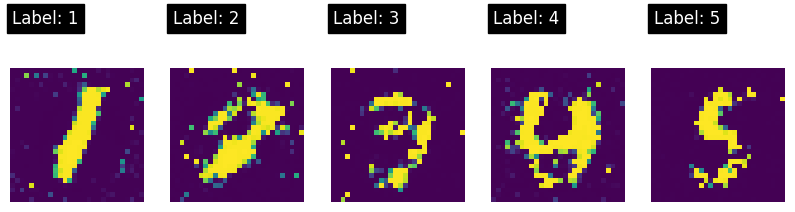

In [24]:
with torch.no_grad():
    data = [1,2,3,4,5]
    fixed_noise = torch.randn(5, 100).to(device)
    label = torch.LongTensor(data).to(device)
    img_fake = model_gen(fixed_noise, label).detach().to(device)

    plt.figure(figsize=(10,10))
    for ii in range(5):
        plt.subplot(1,5,ii+1)
        plt.imshow(to_pil_image(img_fake[ii]))
        plt.text(0, -10, f'Label: {data[ii]}', fontsize=12, color='white', backgroundcolor='black')
        plt.axis('off')